In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
'''
NOTE: These parameters are ajusted for a very fast training stage
 if you have a cuda-enabled GPU and free time you can try to tune 
 them to optain an optimal performance
'''

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 16 # timesteps
n_hidden = 200 # hidden layer num of features
n_output = 28 # MNIST total classes (0-9 digits)


training_iters = 10000

batch_size = 200

In [3]:
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y_ = tf.placeholder("float", [None, n_output])

w_fc1 = tf.Variable(tf.random_normal([n_input, n_hidden])) # Hidden layer weights
b_fc1 = tf.Variable(tf.random_normal([n_hidden]))

w_fc2 = tf.Variable(tf.random_normal([n_hidden, n_output]))
b_fc2 = tf.Variable(tf.random_normal([n_output]))

# input shape: (batch_size, n_steps, n_input)
x_internal = tf.transpose(x, [1, 0, 2])
x_internal = tf.reshape(x_internal, [-1, n_input]) # (n_steps*batch_size, n_input)

lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
istate = lstm_cell.zero_state(batch_size*(28-n_steps), tf.float32)


h_fc1 = tf.nn.relu(tf.matmul(x_internal, w_fc1) + b_fc1)
h_fc1 = tf.split(0, n_steps, h_fc1) # n_steps * (batch_size, n_hidden)
outputs, states = rnn.rnn(lstm_cell, h_fc1, dtype=tf.float32)
y = tf.nn.sigmoid(tf.matmul(outputs[-1], w_fc2) + b_fc2)


#mse = tf.reduce_mean(tf.square(y_-y)) # MSE loss
#optimizer = tf.train.AdamOptimizer(0.0015).minimize(mse)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [120]:
#''' 
# This function creates several training sequences from each
# MNIST sample image, each training sequence consists of #n_steps samples
# with 28 features.
#'''

#def sequencesFromTrainingData(data, nSteps):
    
#    X = []
#    Y = []
    
#    for sample in data:
#        sample = sample.reshape((28,28))
#        for i in range(28-nSteps):
#            X.append(sample[i:i+nSteps,:])
#            Y.append(sample[i+nSteps][:])
#    return np.asarray(X), np.asarray(Y)
        


In [121]:
# Initializing the variables
#init = tf.initialize_all_variables()

#step = 1

#for i in range(training_iters):
#    batch_xs,_ = mnist.train.next_batch(batch_size)
#    batch_xs, batch_ys = sequencesFromTrainingData(batch_xs, n_steps)
#    sess.run(optimizer, feed_dict={x: batch_xs, y_: batch_ys})
#    if step % 100 == 0:
#        loss = sess.run(mse, feed_dict={x: batch_xs, y_: batch_ys})
#        print "Iter " + str(step) + ", Minibatch Loss= " + "{:.6f}".format(loss)
#    step += 1
    
#print "Optimization Finished!" 

In [119]:
#saver = tf.train.Saver()
#save_path = saver.save(sess, "./LSTM.ckpt")
#print("Model saved in file: %s" % save_path)

In [4]:
saver = tf.train.Saver()
saver.restore(sess, "./LSTM.ckpt")
print("Model restored!")

Model restored!


(62, 784)


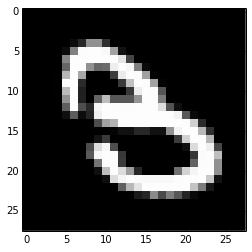

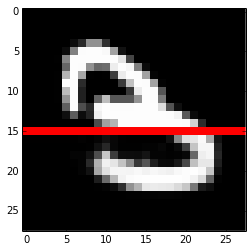

In [5]:
'''
Here the trained network is used to reconstruct a digit in a more difficult way.
The network observes only the #n_steps first rows of the original image 
and then it tries to reconstruct the rest

Note that the window of #n_steps observerd rows moves down as the digit is reconstructed so
each predicted row is considered as part of the input for the next prediction. 
'''

import matplotlib as mpl 

batchX, batchY = mnist.test.next_batch(600)

digits = np.argmax(batchY, axis=1) == 3
print batchX[digits].shape
sample = batchX[digits][0].reshape(28,28)


plt.imshow(sample, interpolation="none", cmap="gray")
plt.show()



line = np.zeros((28,28))
line[n_steps, :] = 1
line = np.ma.masked_where(y == 0, y)



for i in range(28-n_steps):
    p = sess.run(y, feed_dict={x: [sample[i:i+n_steps,:]],
                          istate: np.zeros((1, 2*n_hidden))} )
    sample[i+n_steps] = p

sampleRGB = np.zeros((28,28,3))   

sampleRGB[:,:,0] = sample
sampleRGB[:,:,1] = sample
sampleRGB[:,:,2] = sample

sampleRGB[15,:,:] = 0
sampleRGB[15,:,0] = 1
    
# The red line divides the observed part from the reconstructed part.
# Note that sometimes the net can not identify the digit correctly 
# but it draws a consistent digit anyway    
    
plt.imshow(sampleRGB, interpolation="none")
